## Цель исследования

Определить повлияло ли изменение шрифта в приложении на конверсию.

## Ход исследования:

- Изучить данные, провести обработку данных, определить базовые данные исследования: период, количество пользователей в группах, события
- Исследовать текущий датасет по ключевым параметрам: построить воронку по событиям, определить конверсии каждого события.
- Провести A/A и A/B тестирования, написать функции позволяющие автоматизировать сравнение конверсий

## Оглавление

[Шаг 1. Откройте файл с данными и изучите общую информацию](#1)  

[1.1 Обзор данных](#11)  
[1.2 Исследование данных](#12)  
[1.3 Преобразование и проверка данных](#13)  

[Шаг 2. Подготовьте данные](#2)  

[Шаг 3. Изучите и проверьте данные](#3)  

[Шаг 4. Изучите воронку событий](#4)  
[4.1. Подготовка воронки событий](#41)  
[4.2. Воронка событий](#42)  

[Шаг 5. Изучите результаты эксперимента](#5)  

[5.1. Подготовка данных к A/B тесту](#51)  
[5.2. A/A эксперимент](#52)  
[5.3. A/B эксперимент](#53)  

### Шаг 1. Откройте файл с данными и изучите общую информацию<a name="1"></a>

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import math as mth
from scipy import stats as st
from plotly import graph_objects as go
import plotly.express as px

In [2]:
try:
    path = '/datasets/logs_exp.csv'
    df = pd.read_csv(path, sep='\t')
except:
    path = 'C:/Users/maxbe/Desktop/Яндекс.Практикум/python проекты/ya_project_collecting_2/logs_exp.csv'
    df = pd.read_csv(path, sep='\t')

### Шаг 2. Подготовьте данные<a name="2"></a>

- Замените названия столбцов на удобные для вас
- Проверьте пропуски и типы данных. Откорректируйте, если нужно
- Добавьте столбец даты и времени, а также отдельный столбец дат

Информация о датасете

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
df.sample(2)

,EventName,DeviceIDHash,EventTimestamp,ExpId
115623,MainScreenAppear,6929303458198089480,1564909365,248
195875,MainScreenAppear,3296122068432336013,1565098637,247


Заменим тип данных EventTimestamp на datetime64[ns]

In [5]:
df['EventTimestamp'] = pd.to_datetime(df['EventTimestamp'], unit='s')

Проверка

In [6]:
df.dtypes

EventName                 object
DeviceIDHash               int64
EventTimestamp    datetime64[ns]
ExpId                      int64
dtype: object

Заменим названия столбцов

In [7]:
df = df.rename(columns={'EventName' : 'event', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'datetime', 'ExpId': 'group'})

Проверка

In [8]:
df.sample(2)

,event,user_id,datetime,group
160457,CartScreenAppear,6613527411922640441,2019-08-05 13:58:25,246
2133,MainScreenAppear,5894170077720152065,2019-07-31 21:20:39,248


**Проверка на явные дубликаты**

In [9]:
print('Дублей в датасете:', df.duplicated().sum())

Дублей в датасете: 413


т.к. есть точное время и идентификатор пользователя у нас не может быть одинаковых строк.  
Скорее всего это ошибка записи данных.  
Удалим явные дубликаты

In [10]:
df = df.drop_duplicates().reset_index(drop=True) 

In [11]:
print('Дублей в датасете после очистки:', df.duplicated().sum())

Дублей в датасете после очистки: 0


**Проверка на пропуски**

In [12]:
df.isna().sum()

event       0
user_id     0
datetime    0
group       0
dtype: int64

Добавим столбец дат

In [13]:
df['date'] = pd.to_datetime(df['datetime']).dt.date

In [14]:
df['date'] = df['date'].astype('datetime64[ns]')

In [15]:
df.sample(2)

,event,user_id,datetime,group,date
84871,MainScreenAppear,7787161900943974716,2019-08-03 10:02:57,248,2019-08-03
171964,PaymentScreenSuccessful,2457989834692826118,2019-08-05 18:21:24,248,2019-08-05


Проверим на неявные дубликаты столбцы 'group' и 'event'

In [16]:
df['group'].unique()

array([246, 248, 247], dtype=int64)

In [17]:
df['event'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Проверка на уникальность пользователей в группах (один пользователь не должен быть в двух группах)

In [18]:
users_246 = df[df['group'] == '246']['user_id'].unique()
users_247 = df[df['group'] == '247']['user_id'].unique()
users_248 = df[df['group'] == '248']['user_id'].unique()

visitors_dubbled = pd.Series(np.intersect1d(users_246, users_247))
print('Количество пересекающихся пользователей 246 и 247:', len(visitors_dubbled))
visitors_dubbled = pd.Series(np.intersect1d(users_247, users_248))
print('Количество пересекающихся пользователей 247 и 248:', len(visitors_dubbled))
visitors_dubbled = pd.Series(np.intersect1d(users_246, users_248))
print('Количество пересекающихся пользователей 246 и 248:', len(visitors_dubbled))

Количество пересекающихся пользователей 246 и 247: 0
Количество пересекающихся пользователей 247 и 248: 0
Количество пересекающихся пользователей 246 и 248: 0


<div style="border:solid purple 2px; padding: 20px">  
    
Итоги предобраотки:
- пропуск отсутствуют
- явные дубликаты удалили
- неявные дубликаты отсутствуют
- заменили названия столбцов
- добавили дату без времени

</div>

### Шаг 3. Изучите и проверьте данные<a name="3"></a>

**Озор данных**
- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период вы располагаете?
- Найдите максимальную и минимальную дату

**Исследование данных**  
- Постройте гистограмму по дате и времени.  
- Можно ли быть уверенным, что у вас одинаково полные данные за весь период? 

**Преобразование и проверка данных**
- Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
- Много ли событий и пользователей вы потеряли, отбросив старые данные?
- Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

### Обзор данных<a name="11"></a>

In [19]:
print('Событий в логе:', len(df['event']))
print('Пользователей в логе:', len(df['user_id'].unique()))
avg_events = round(len(df['event']) / len(df['user_id'].unique()), 2)
print('Событий в среднем на одного пользователя:', avg_events)

Событий в логе: 243713
Пользователей в логе: 7551
Событий в среднем на одного пользователя: 32.28


In [20]:
first_date = df['datetime'].min().strftime("%d %b %Y, %H:%M:%S")
last_date = df['datetime'].max().strftime("%d %b %Y, %H:%M:%S")
date_diff = df['datetime'].max() - df['datetime'].min()
print(f'События в логах за период с {first_date} по {last_date}')
print('Общая продолжительность периода с логами:', str(date_diff))

События в логах за период с 25 Jul 2019, 04:43:36 по 07 Aug 2019, 21:15:17
Общая продолжительность периода с логами: 13 days 16:31:41


In [21]:
print('Минимальная дата:', first_date)
print('Максимальная дата:', last_date)

Минимальная дата: 25 Jul 2019, 04:43:36
Максимальная дата: 07 Aug 2019, 21:15:17


### Исследование данных<a name="12"></a>

Постройте гистограмму по дате и времени.

In [22]:
date_count = df.groupby('date').agg({'event': 'count'}).reset_index()

In [23]:
date_count = date_count.rename(columns={'event' : 'count'})

In [24]:
date_count

,date,count
0,2019-07-25,9
1,2019-07-26,31
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,412
6,2019-07-31,2030
7,2019-08-01,36141
8,2019-08-02,35554
9,2019-08-03,33282


In [25]:
keys = list(date_count['date'])
vals = list(date_count ['count'])

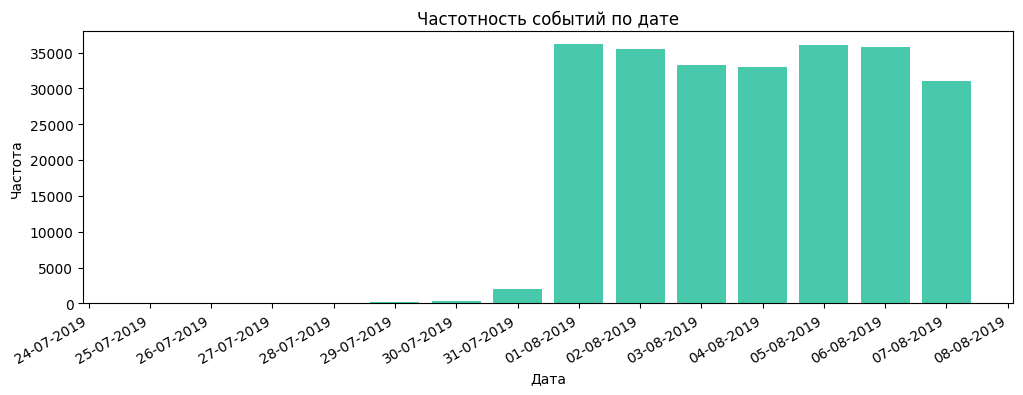

In [26]:
plt.figure(figsize=(12, 4))
plt.bar(keys, vals, color='#48C9AB')
ax = plt.gca()

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()
plt.xlabel('Дата');
plt.ylabel('Частота');
plt.title('Частотность событий по дате');
plt.show()

<div style="border:solid purple 2px; padding: 20px">  
    
Мы не можем быть уверены, что у нас полные данные за весь период.  
Исходя из данных A/B тест скорее всего полноценно старовал 01.08.2019 и продолжался неделю по 07.08.2019.

Возьмем данные за период с 01.08.2019 по 07.08.2019.  
Удалим остальные данные.
</div>

### Преобразование и проверка данных<a name="13"></a>

Удалим данные за периоды с 2019-07-24 по 2019-07-31 и за 2019-08-08

In [27]:
before_drop = len(df)
u_before_drop = len(df['user_id'].unique())
print('До удаления было записей:', before_drop)
print('До удаления было пользователей:', u_before_drop)

До удаления было записей: 243713
До удаления было пользователей: 7551


In [28]:
drop_dates = pd.date_range(
    '24-07-2019',
    '31-07-2019'
).strftime('%Y-%m-%d').tolist()

In [29]:
drop_dates.append('2019-08-08')

In [30]:
drop_dates

['2019-07-24',
 '2019-07-25',
 '2019-07-26',
 '2019-07-27',
 '2019-07-28',
 '2019-07-29',
 '2019-07-30',
 '2019-07-31',
 '2019-08-08']

In [31]:
df['date_str'] = df['date'].apply(lambda x: str(x))

In [32]:
df['date_str'] = df['date_str'].apply(lambda x: x[0:10])

In [33]:
df.drop(df.loc[df['date_str'].isin(drop_dates)].index, inplace=True)

In [34]:
df.drop(columns=['date_str']);

In [35]:
print(' После удаления стало записей:', len(df))
print(' Было удалено данных', before_drop-len(df), '\n', 'Удаленных %', round(before_drop/len(df),2))

 После удаления стало записей: 240887
 Было удалено данных 2826 
 Удаленных % 1.01


In [36]:
print(' После удаления стало Пользователей:', len(df['user_id'].unique()))
print(' Было удалено пользователей', u_before_drop-len(
    df['user_id'].unique()), '\n', 'Удаленных %', round((u_before_drop-len(
        df['user_id'].unique()))/len(df['user_id'].unique()), 2))

 После удаления стало Пользователей: 7534
 Было удалено пользователей 17 
 Удаленных % 0.0


Событий удалили 2826, но пользователей осталось столько же, значит у этих пользователей было несколько действий.

Посчитаем заново события в расчете на пользователя

In [37]:
avg_events = round(len(df['event']) / len(df['user_id'].unique()), 2)
print('Событий в среднем на одного пользователя:', avg_events)

Событий в среднем на одного пользователя: 31.97


Посчитаем сколько пользователей в каждой группе

In [38]:
print('Групп в датасете', *df['group'].unique(), '\n')
print('Пользователей в группе 246:', len(df[df['group'] == 246]['user_id'].unique()))
print('Пользователей в группе 247:', len(df[df['group'] == 247]['user_id'].unique()))
print('Пользователей в группе 248:', len(df[df['group'] == 248]['user_id'].unique()))

Групп в датасете 246 247 248 

Пользователей в группе 246: 2484
Пользователей в группе 247: 2513
Пользователей в группе 248: 2537


Все группы на месте, количество пользователей распределено равномерно, можно работать.

<div style="border:solid purple 2px; padding: 20px">  
    
По итогам данного блока:
- Были удалены события не входящие в период исследования, событий удалено 2826, пользователей удалено 17
- Определены минимальная и максимальная дата датасета '2019-08-01' по '2019-08-07'
- Определен период исследования - 1 неделя
- Удалены даты с недостаточным объемом данных
- Изучили данные: событий 240 887, в среднем событий на одного пользователя 31.97, пользователей в каждой группе 2500 +- 50

</div>

### Шаг 4. Изучите воронку событий<a name="4"></a>

**Подготовка воронки событий**
- Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.  
- Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.  
- Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.  

**Воронка событий**
- По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.  
- На каком шаге теряете больше всего пользователей?  
- Какая доля пользователей доходит от первого события до оплаты?  

### Подготовка воронки событий<a name="41"></a>

**Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте**

In [39]:
df_events = df.groupby('event').agg({'user_id': 'count'}).reset_index()
df_events = df_events.rename(
    columns={'user_id' : 'count'}).sort_values(by='count', ascending=True).reset_index(drop=True)
df_events

,event,count
0,Tutorial,1005
1,PaymentScreenSuccessful,33918
2,CartScreenAppear,42303
3,OffersScreenAppear,46333
4,MainScreenAppear,117328


<div style="border:solid purple 2px; padding: 20px">  
    
Этап с переходом от главного экрана к странице с преложением дает наибольшую просадку.  
Прохождение обучения (инструкции) скорее всего является необязательным этапом, который пользователи пропускают.

</div>

**Посчитаем, сколько пользователей совершали каждое из этих событий.  
Отсортируем события по числу пользователей.  
Посчитаем долю пользователей, которые хоть раз совершали событие.**

In [40]:
df_users = df.groupby('event').agg({'user_id': 'nunique'}).reset_index()
df_users = df_users.rename(columns={'user_id': 'nunique'}).sort_values(by='nunique', ascending=True).reset_index(drop=True)
df_users

,event,nunique
0,Tutorial,840
1,PaymentScreenSuccessful,3539
2,CartScreenAppear,3734
3,OffersScreenAppear,4593
4,MainScreenAppear,7419


Пользователь с одним действием - пользователь совершивший одно любое событие

In [41]:
event_by_users = df.groupby('user_id').agg({'event': 'nunique'}).reset_index()
print('Пользователей, совершивших хотя бы одной дейсвтие:', len(event_by_users.query('event>=1')))
print('Всего пользователей', len(df['user_id'].unique()))
print('% активных пользователей', round(len(event_by_users.query('event>=1'))/len(df['user_id'].unique()) * 100, 1))

Пользователей, совершивших хотя бы одной дейсвтие: 7534
Всего пользователей 7534
% активных пользователей 100.0


<div style="border:solid purple 2px; padding: 20px">  
    
Этап с переходом от главного экрана к странице с преложением дает наибольшую просадку.  
Прохождение обучения (инструкции) скорее всего является необязательным этапом, который пользователи пропускают.  
Также заметно снижение переходов из приложения в корзину.

Самый успешный этап - переход из корзины на экран оплаты.  
100% пользователей совершившили хотя бы одно действие в приложении.   

Наши пользователи очень активны, в среднем пользователь совершает 32 события.
</div>

Запишем события по пользователям без события Tutorial

In [42]:
df_users = df_users.drop([0]).reset_index(drop=True)
df_users

,event,nunique
0,PaymentScreenSuccessful,3539
1,CartScreenAppear,3734
2,OffersScreenAppear,4593
3,MainScreenAppear,7419


**Предположите, в каком порядке происходят события.  
Все ли они выстраиваются в последовательную цепочку?  
Их не нужно учитывать при расчёте воронки.**  

<div style="border:solid purple 2px; padding: 20px"> 
События выстраиваются в логичную цепочку, кроме 'Tutorial'.  
Скорее Tutorial - это необязательная инструкция как пользователя работать с приложением, которая появляется после посещения главной страницы.  
Инструкцию можно удалить из воронки.

Воронка выглядит следующим образом:
1. MainScreenAppear - главная страница
2. OffersScreenAppear - страница товарного предложения (карточка)
3. CartScreenAppear	 - добавление в корзину
4. PaymentScreenSuccessful - успешная оплата товара
</div>

### Воронка событий<a name="42"></a>

**По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки**

In [43]:
df_users

,event,nunique
0,PaymentScreenSuccessful,3539
1,CartScreenAppear,3734
2,OffersScreenAppear,4593
3,MainScreenAppear,7419


In [44]:
df_users.loc[1,'nunique']

3734

In [45]:
conversion = []
for i in range(0, len(df_users['nunique'])):
    if i == 3:
        conversion.append(np.nan)
    else:
        conversion.append(round(df_users.loc[i,'nunique']/df_users.loc[i+1,'nunique'] * 100,2))

In [46]:
df_users['conversion'] = conversion

In [47]:
df_users.loc[3, 'nunique']

7419

**Рассчитаем конверсию из каждого предыдущего события**

In [48]:
print('Конверсия в карточку товара', df_users.loc[2,'conversion'], '%')
print('Конверсия добавление в корзину', df_users.loc[1,'conversion'], '%')
print('Конверсия в оплату', df_users.loc[0,'conversion'], '%', '\n')
conversion_in_payment = round(df_users.loc[0,'nunique'] / df_users.loc[len(df_users['nunique'])-1, 'nunique'] * 100, 2)
print('Конверсия всех посетителей в оплату', conversion_in_payment, '%')

Конверсия в карточку товара 61.91 %
Конверсия добавление в корзину 81.3 %
Конверсия в оплату 94.78 % 

Конверсия всех посетителей в оплату 47.7 %


**Рассчитаем конверсию по отношению к общему числу пользователей**

In [49]:
df_users['users_total'] = len(df['user_id'].unique())

In [50]:
df_users['conversion_by_user'] = round(df_users['nunique'] / df_users['users_total'] * 100, 2)

In [51]:
print('Конверсия пользователя на главную страницу', df_users.loc[3,'conversion_by_user'], '%')
print('Конверсия пользователя в карточку товара', df_users.loc[2,'conversion_by_user'], '%')
print('Конверсия пользователя добавление в корзину', df_users.loc[1,'conversion_by_user'], '%')
print('Конверсия пользователя в оплату', df_users.loc[0,'conversion_by_user'], '%', '\n')
conversion_in_payment = round(df_users.loc[0,'nunique'] / df_users.loc[len(df_users['nunique'])-1, 'nunique'] * 100, 2)

Конверсия пользователя на главную страницу 98.47 %
Конверсия пользователя в карточку товара 60.96 %
Конверсия пользователя добавление в корзину 49.56 %
Конверсия пользователя в оплату 46.97 % 



<div style="border:solid purple 2px; padding: 20px">   
    
Наибольшие потери происходят на начальных этапах - просмотр карточки товара и добавление в корзину.  
Например, до просмотра карточки товара доходит всего 61% пользователей.  
    
Конверсия из корзины в оплату высокая.  
Возможно стоит упростить добавление товаров в корзину или поработать над навигацией каталога.

Общая конверсия в оплату составляется 47%.
</div>

### Шаг 5. Изучите результаты эксперимента<a name="1"></a>

**Подготовка данных к A/B тесту**
- Сколько пользователей в каждой экспериментальной группе?  

**A/A эксперимент**   

- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов.  
Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.  
- Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?  

**A/B эксперимент**  

- Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
- Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

### Подготовка данных к A/B тесту<a name="51"></a>

**Сколько пользователей в каждой экспериментальной группе?**

In [52]:
print('Пользователей в группе 246:', len(df[df['group'] == 246]['user_id'].unique()))
print('Пользователей в группе 247:', len(df[df['group'] == 247]['user_id'].unique()))
print('Пользователей в группе 248:', len(df[df['group'] == 248]['user_id'].unique()))

Пользователей в группе 246: 2484
Пользователей в группе 247: 2513
Пользователей в группе 248: 2537


In [53]:
print('Разница в количестве пользователей между контрольными группами составляет:', 
    round((len(df[df['group'] == 247]['user_id'].unique())-len(
        df[df['group'] == 246]['user_id'].unique())) / len(df[df['group'] == 247]['user_id'].unique()) * 100, 2),'%')

Разница в количестве пользователей между контрольными группами составляет: 1.15 %


Разница в количестве пользователей в контрольных группах небольшая.  
Есть две контрольные группы: 246 и 247.  
Пользователи этих групп не видели изменения шрифта.  
Чтобы определить, что данные системы аналитики корректны и достоверны проведем сначала тест между контрольными группами (A/A).

**Сгруппируем датасет по событиям в группах. Сформируем датасет для A/A и A/B тестов.**

In [54]:
users_by_groups = df.pivot_table(
    index='group', columns='event', values='user_id', aggfunc='nunique')

In [55]:
users_by_groups

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
group,,,,,
246,1266,2450,1542,1200,278
247,1238,2476,1520,1158,283
248,1230,2493,1531,1181,279


Добавим данные по общему количеству пользователей каждой группы

In [56]:
unique_users = []
unique_users.append(len(df[df['group'] == 246]['user_id'].unique()))
unique_users.append(len(df[df['group'] == 247]['user_id'].unique()))
unique_users.append(len(df[df['group'] == 248]['user_id'].unique()))

In [57]:
users_by_groups['Users'] = unique_users

In [58]:
users_by_groups

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,Users
group,,,,,,
246,1266,2450,1542,1200,278,2484
247,1238,2476,1520,1158,283,2513
248,1230,2493,1531,1181,279,2537


Объединим данные контрольных групп 246 и 247 

In [59]:
users_by_groups.sum(axis=0).values

array([3734, 7419, 4593, 3539,  840, 7534], dtype=int64)

In [60]:
users_by_groups.loc['246+247'] = users_by_groups.sum(axis=0).values

Создадим таблицу, где будет конверсия каждого события в разрезе групп

In [61]:
users_by_groups.index.values

array([246, 247, 248, '246+247'], dtype=object)

In [62]:
coversion_by_groups = {'Group': list(users_by_groups.index)}
coversion_by_groups = pd.DataFrame(coversion_by_groups)
for i in users_by_groups.columns[0:5]:
    coversion_by_groups[i] = list(round(users_by_groups[i] / users_by_groups['Users'] * 100, 2))

In [63]:
coversion_by_groups

,Group,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
0,246,50.97,98.63,62.08,48.31,11.19
1,247,49.26,98.53,60.49,46.08,11.26
2,248,48.48,98.27,60.35,46.55,11.00
3,246+247,49.56,98.47,60.96,46.97,11.15


Финальная таблица для A/A и A/B тестов

In [64]:
users_by_groups

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,Users
group,,,,,,
246,1266,2450,1542,1200,278,2484
247,1238,2476,1520,1158,283,2513
248,1230,2493,1531,1181,279,2537
246+247,3734,7419,4593,3539,840,7534


### А/А-эксперимент<a name="52"></a>

_______________________________________________________________________________________________________________________________
**Сформулируем гипотезы**

Нулевая гипотеза:  
H0 - конверсия пользователя в оплату в контрольных группах 246 и 247 **не различается**

Альтернативная гипотеза:  
H1 - конверсия пользователя в оплату в контрольных группах 246 и 247 **различается**
_______________________________________________________________________________________________________________________________

**Применим Z-критерий для нахождения p-value.  
Напишем функцию для вычисления p-value с помощью z-критерия.  
Сравним конверсию в покупку для групп 246 и 247**

Функция принимает на вход:  
    
- success1 - успех первой группы (покупка)  
- gr1 - размер первой группы  
- success2 - успех второй группы (покупка)  
- gr2 - размер второй группы  
- alph - уровень статистической значимости

Возвращает два аргумента:
- output - текстовый вывод результата теста
- p_value - значение p-value

In [65]:
def z_value(success1, gr1, success2, gr2, alph):
    alpha = alph  # критический уровень статистической значимости

    p1 = success1/gr1 # пропорция успехов в первой группе
    p2 = success2/gr2 # пропорция успехов во второй группе
    p_combined = (success1+success2) / (gr1+gr2)

    difference = p1 - p2
    z = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/gr1 + 1/gr2))
    distr = st.norm(0, 1)
    p_value = round((1 - distr.cdf(abs(z))) * 2, 4)
    if p_value < alpha:
        output = 'Отвергаем H0, конверсии отличаются'
    else:
        output = 'Принимаем H0, конверсии не отличаются'
    return output, p_value

Добавим данные на вход в функцию.

In [66]:
group1 = users_by_groups.loc[246, 'Users']
res1= users_by_groups.loc[246, 'PaymentScreenSuccessful']
group2 = users_by_groups.loc[247, 'Users']
res2= users_by_groups.loc[247, 'PaymentScreenSuccessful']

In [67]:
z_value(res1, group1, res2, group2, 0.05);

In [68]:
print(' p-value', z_value(res1, group1, res2, group2, 0.05)[1], '\n', z_value(res1, group1, res2, group2, 0.05)[0])

 p-value 0.1146 
 Принимаем H0, конверсии не отличаются


<div style="border:solid purple 2px; padding: 20px">   
    
Полученное значение p-value говорит о том, что вероятность получить одинаковые значения большая, а именно 11.46%.  
Такая вероятность больше целевых 5%, чтобы делать вывод о значимом различии между конверсиями контрольных групп.    

Данные получаемые из системы аналитики достоверны, разбиение на группы корректно, можно проводить основной A/B тест.
</div>

**Проведем A/A тест для всех других событий**

In [69]:
users_by_groups.columns

Index(['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful', 'Tutorial', 'Users'],
      dtype='object', name='event')

Сохраним события в отдельный список для работы в цикле

In [70]:
AA_events = list(users_by_groups.columns)

In [71]:
AA_events = [i for i in AA_events if i not in ('PaymentScreenSuccessful', 'Users')]

_______________________________________________________________________________________________________________________________
**Сформулируем универсальную гипотезу**

Нулевая гипотеза:  
H0 - конверсия пользователя для события **N** группах 246 и 247 **не различается**

Альтернативная гипотеза:  
H1 - конверсия пользователя для события **N** в контрольных группах 246 и 247 **различается**
_______________________________________________________________________________________________________________________________

In [72]:
for i in AA_events:
    group1 = users_by_groups.loc[246, 'Users']
    res1= users_by_groups.loc[246, i]
    group2 = users_by_groups.loc[247, 'Users']
    res2= users_by_groups.loc[247, i]
    print('\n',f' Статистический тест для события {i}'.center(90), '\n')
    y = z_value(res1, group1, res2, group2, 0.05)
    print('p-value:', y[1])
    print(y[0])


                      Статистический тест для события CartScreenAppear                      

p-value: 0.2288
Принимаем H0, конверсии не отличаются

                      Статистический тест для события MainScreenAppear                      

p-value: 0.7571
Принимаем H0, конверсии не отличаются

                     Статистический тест для события OffersScreenAppear                     

p-value: 0.2481
Принимаем H0, конверсии не отличаются

                          Статистический тест для события Tutorial                          

p-value: 0.9377
Принимаем H0, конверсии не отличаются


<div style="border:solid purple 2px; padding: 20px">   
    
Ни по одному из событий статистический тест не показал различие в конверсии.

Данные получаемые из системы аналитики достоверны, разбиение на группы корректно, можно проводить основной A/B тест.

</div>

### А/B-эксперимент<a name="53"></a>

_______________________________________________________________________________________________________________________________
**Сформулируем гипотезы**

Нулевая гипотеза:  
H0 - конверсия пользователя в экспериментальной и контрольной группах 246 и 247 **не различается**

Альтернативная гипотеза:  
H1 - конверсия пользователя в экспериментальной и контрольной группах 246 и 247 **различается**
_______________________________________________________________________________________________________________________________

**Проведем А/B-эксперимент для экспериментальной группы.  
Сравним экспериментальную группу с двумя контрольными и объединенной.**  

Использовать будем ранее написанную функцию Z-критерия.  
p-value определим на уровне 5%.  

Этот уровень обаладает достаточной чувствительностью для приложения.  
Больший уровень чувсвительности нужен в отраслях, требующих большей точности.  
Например, медицинская.  

Напишем функцию , которая получает на вход dataframe с событиями и возвращает dataframe с результатами статистического теста.  

Функция будет принимать на вход:
- экспериментальную группу (название)
- название столбца с общим количеством пользователей
- dataframe, в котором:  
строки - это группы  
столбцы - это события  
значения - это количество пользователей, совершившее событие  

Возвращать  
- dataframe, где экспериментальная группа сравнивается с контрольными группами:  
строки - это события  
столбцы - это результат стат.теста и вывод для каждой группы

In [73]:
def z_value_dataframe(gr_name, u_name, df):
    AB_groups = list(df.index.values)
    AB_events = list(df.columns)
    AB_groups.remove(gr_name)
    AB_events.remove(u_name)
    data = {'Event': AB_events}
    dataframe = pd.DataFrame(data)
    for j in AB_groups:
        test_values = []
        test_results = []
        for i in AB_events:
            group1 = users_by_groups.loc[gr_name, u_name]
            res1= users_by_groups.loc[gr_name, i]
            group2 = users_by_groups.loc[j, u_name]
            res2= users_by_groups.loc[j, i]
            result = z_value(res1, group1, res2, group2, 0.05)
            test_values.append(result[1])
            test_results.append(result[0])
        col_v = str(j) + ' p-value '
        col_r = str(j) + ' result'
        dataframe[col_v] = test_values
        dataframe[col_r] = test_results
    return dataframe

In [74]:
print(f'Сравнение экспериментальной группы с контрольными'.center(120))
z_value_dataframe(248, 'Users', users_by_groups)

                                   Сравнение экспериментальной группы с контрольными                                    


,Event,246 p-value,246 result,247 p-value,247 result,246+247 p-value,246+247 result
0,CartScreenAppear,0.0784,"Принимаем H0, конверсии не отличаются",0.5786,"Принимаем H0, конверсии не отличаются",0.3469,"Принимаем H0, конверсии не отличаются"
1,MainScreenAppear,0.2950,"Принимаем H0, конверсии не отличаются",0.4587,"Принимаем H0, конверсии не отличаются",0.4674,"Принимаем H0, конверсии не отличаются"
2,OffersScreenAppear,0.2084,"Принимаем H0, конверсии не отличаются",0.9198,"Принимаем H0, конверсии не отличаются",0.5820,"Принимаем H0, конверсии не отличаются"
3,PaymentScreenSuccessful,0.2123,"Принимаем H0, конверсии не отличаются",0.7373,"Принимаем H0, конверсии не отличаются",0.7121,"Принимаем H0, конверсии не отличаются"
4,Tutorial,0.8264,"Принимаем H0, конверсии не отличаются",0.7653,"Принимаем H0, конверсии не отличаются",0.8329,"Принимаем H0, конверсии не отличаются"


**Вывод**


<div style="border:solid purple 2px; padding: 20px">   
    
Ни по одному из событий статистический тест не показал различие в конверсии экспериментальной группы с контрольными.  
Полученное значение p-value показывает вероятность получить одинаковые значения.  
Если вероятность больше 5%, то мы не можем делать вывод о значимом различии между конверсиями экспериментальной и контрольной групп.  
Все вероятности получить одинаковые значения лежат в диапазоне выше 5%.

Менеджеры зря опасались падения конверсии, замена шрифтов повлияет на конверсию пользователей в приложении.  
Можно оставить новые шрифты и провести A/B тест на большем периоде времени (2-3 недели).  
С помощью уже написанных функций проверить результаты повторно.

</div>

<div style="border:solid purple 2px; padding: 20px">   
    
Итого в проектной работе:  
    
- предобработали данные: удалили дубликаты, добавили столбец с датой, перименовали столбцы  
- изучили датасет: количество пользователей, конверсии каждого этапа, общая конверсия в покупку, вывели конверсии по каждому событию в разрезе групп  
- провели A/A и A/B тесты для каждого события, автоматизировали тесты с помощью функций, выявили отсутствие различий между группами  

</div>